## Very Basic Interferometer Simulator

Freely adapted from pynterferometer http://www.jb.man.ac.uk/pynterferometer/download.html

- Interferometer simulator for aperture synthesis of an image centered in the zenith from a monochromatic telescope array in a non-rotating frame (snapshot)
- Free parameters:
    - Frequency 
    - Number of antennae (between 2 and 50)
- Image should be square, but pixel width is free (by default, the array will be set to a resolution of 1 pixel)
- Resolution can be changed (between 1 and the image pixel width)

In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filenamein="palomas.png"
freq=1e10               # Frequency
wavel=3e8/freq          # Wavelength

BALLS = 10 # number of antennae

if BALLS<=1:
    BALLS=2
    print("You have 2 antennae now") # avoid single-antenna observations
if BALLS>50:
    BALLS=50
    print("You have 50 antennae now") # we only have 50 available antennae

(1000, 1000)


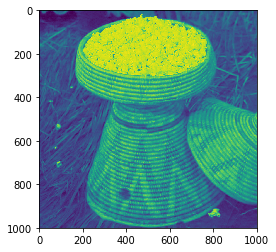

In [3]:
in_img=mpimg.imread(filenamein) #image
in_img=in_img[:,:,0] #select a single colour plane from a RBG image
img_siz=in_img.shape #input image dimensions
WIDTH, HEIGHT=in_img.shape # get image size (must be square)
print(WIDTH, HEIGHT)
plt.imshow(in_img); # plot original image

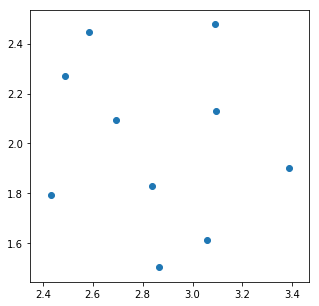

In [4]:
# ALMA extended configuration in a [0,1]x[0,1] square
almal_x=[  5.37451571e-01,   5.85665088e-01,   5.10331468e-01,   4.71301478e-01,
   5.79351413e-01,   5.85378103e-01,   4.60539532e-01,   6.41196728e-01,
   4.89883771e-01,   5.42545559e-01,   6.35241785e-01,   4.30477830e-01,
   6.49591046e-01,   5.21236906e-01,   4.67498924e-01,   5.42473813e-01,
   5.80212369e-01,   5.10546707e-01,   7.17247812e-01,   4.68869278e-01,
   3.33405080e-01,   7.67097144e-01,   6.71990243e-01,   3.54763955e-01,
   8.33003300e-01,   8.17692639e-01,   2.09212226e-01,   8.00107619e-01,
   8.20261157e-01,   8.25599082e-01,   7.99655618e-01,   8.36131439e-01,
   9.00000000e-01,   8.05997991e-01,   9.29939733e-01,   4.33053523e-01,
   4.14542976e-01,   2.38699957e-01,   7.21337351e-01,   8.64930406e-01,
   9.34926101e-01,   8.50631367e-01,   8.47610850e-02,   7.88556464e-01,
   9.05294877e-01,   1.04749605e-01,   8.30750466e-01,   1.00000000e+00,
   7.17463000e-05,   9.46039604e-01][:BALLS]
almal_y=[  3.46786220e-01,   4.03165015e-01,   3.96935661e-01,   4.30033034e-01,
   3.05257197e-01,   4.69170993e-01,   3.39361334e-01,   3.60251691e-01,
   4.63193330e-01,   2.84681454e-01,   4.60613497e-01,   3.78121756e-01,
   3.09284254e-01,   5.12587699e-01,   3.12493314e-01,   3.49114362e-01,
   4.05493157e-01,   4.02158251e-01,   5.22214881e-01,   6.07028473e-01,
   5.14475381e-01,   5.49548529e-01,   2.14661004e-01,   5.16759478e-01,
   2.61249017e-01,   5.25046406e-01,   5.02834670e-01,   6.29228000e-05,
   7.18754129e-01,   5.51838918e-01,   2.49690105e-01,   5.85955639e-01,
   2.60154161e-01,   5.47698600e-01,   9.01720938e-01,   6.35840805e-01,
   6.43920088e-01,   5.07365109e-01,   1.13474910e-01,   6.04970898e-01,
   4.29322010e-02,   6.24338524e-01,   5.01129464e-01,   4.94069530e-02,
   7.89592575e-01,   4.61997798e-01,   6.77401290e-01,   2.09721570e-02,
   4.20342929e-01,   1.00000000e+00][:BALLS]

# calculate relative positions between antennae (only used to find max baseline)
almal_lx=np.zeros((len(almal_x),len(almal_x)))
almal_ly=np.zeros((len(almal_y),len(almal_x)))
for i in range(len(almal_x)):
    for j in range(len(almal_y)):
        almal_lx[i,j]=(almal_x[i]-almal_x[j])
        almal_ly[i,j]=(almal_y[i]-almal_y[j])
        
# get max baseline in original array (between 0 and sqrt(2))
# this ensures that the max baseline is scaled to one
bl_scaled=(np.sqrt(almal_lx**2+almal_ly**2)).max()


x=np.array(almal_x)/bl_scaled
y=np.array(almal_y)/bl_scaled


N=len(x)*(len(x)-1)                     #number of baselines

lx=np.zeros((len(x),len(x)))
ly=np.zeros((len(y),len(x)))

# calculate relative positions between antennae (for the visibilities)
for i in range(len(x)):
    for j in range(len(y)):
        lx[i,j]=(x[i]-x[j])
        ly[i,j]=(y[i]-y[j])
plt.figure(figsize=(5,5))
plt.scatter(x,y)
plt.axis("equal");

In [5]:
u=(np.ceil(ly/wavel))            # u values
v=(np.ceil((-1.*lx)/wavel))      # v values
re_u=np.reshape(u,(len(x)**2),order='F') #reshape u into linear form
re_v=np.reshape(v,(len(y)**2),order='F') #reshape v into linear form

In [6]:
# find max uv coverage
scfac=2*np.sqrt((re_u**2+re_v**2)).max() # max uv distance (will be used to scale uv coverage)

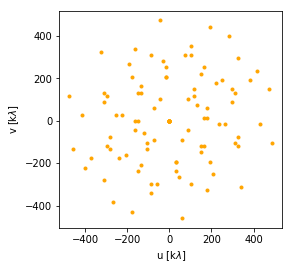

In [7]:
# scale uv points to cover the image width (in pixels)
# this way we have a resolution of exactly 1 px
ore_u=re_u*WIDTH/scfac 
ore_v=re_v*WIDTH/scfac

# plot uv coverage
fig_uv = plt.figure(8,figsize=[4,4]) 
fig_uv.clear()
ax_uv = fig_uv.add_subplot(111)
ax_uv.plot(ore_u,ore_v,'.',color='orange')
ax_uv.tick_params(axis='both',labelsize='10')
ax_uv.set_xlabel('u [k$\lambda$]',size='10')
ax_uv.set_ylabel('v [k$\lambda$]',size='10')
fig_uv.savefig('uvplot.png', dpi=150, facecolor='w', edgecolor='w',
    orientation='portrait', papertype=None, format=None,
    transparent=False,bbox_inches='tight',pad_inches=0.05)

In [8]:
# create an empty matrix same size as in image for multiplying with fft of true sky image
# this acts as a mask in fourier space (resolution of exactly 1 px)
obs_uv_matrix=np.zeros(img_siz)          
for k in range(len(ore_u)): 
    int_u=int((ore_u)[k])
    int_v=int((ore_v)[k])
    obs_uv_matrix[int_u,int_v]=1.0

obs_uv_matrix[0,0]=0.0  
print('Available uv grid points:',(obs_uv_matrix>0).sum(),'Total visibilities:',N)

('Available uv grid points:', 88, 'Total visibilities:', 90)


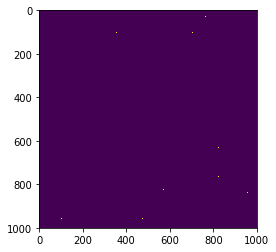

In [9]:
plt.imshow(obs_uv_matrix) # mask

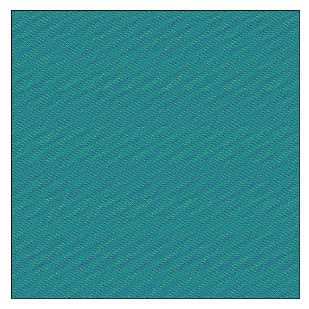

In [10]:
# Transform image to Fourier space, then multiply with uv mask and then apply the inverse FFT to reconstruct image
# Max resolution uv coverage

fft_img=np.fft.fft2(in_img)              #This is the complex visibility from a complete and ideal array from u,v =0,0 outward.
observed=fft_img*obs_uv_matrix           #Observed complex visibility. Combines ideal visibility with the observed uv points, removing those not seen by the selected array configuration.
ifft_img=np.fft.ifft2(observed)          #inverse FFTs the observed visibility
real_ifft_img=ifft_img.real              #Takes real part only for plotting

fig_obs = plt.figure(4, figsize=[4,4]) 
fig_obs.clear()
fig_obs.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax_obs=fig_obs.add_subplot(111)
ax_obs.imshow(real_ifft_img)                #Show observed version of input image.
ax_obs.get_xaxis().set_visible(False)
ax_obs.get_yaxis().set_visible(False)
fig_obs.savefig('output.png', dpi=150, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=None)

In [19]:
# manual resolution input
myres=100. # in pixels
if myres < 1:
    print("Resolution cannot be smaller than 1 px")
    print("Resolution automatically set to 1 px")
    myres=1.
ore_u=re_u*WIDTH/(myres*scfac)
ore_v=re_v*WIDTH/(myres*scfac) 

# create an empty matrix same size as in image for multiplying with fft of true sky image
# this acts as a mask in fourier space (resolution of exactly 1 px)
obs_uv_matrix=np.zeros(img_siz)          
for k in range(len(ore_u)): 
    int_u=int((ore_u)[k])
    int_v=int((ore_v)[k])
    obs_uv_matrix[int_u,int_v]=1.0

obs_uv_matrix[0,0]=0.0  
print('Available uv grid points:',(obs_uv_matrix>0).sum(),'Total visibilities:',N)

('Available uv grid points:', 49, 'Total visibilities:', 90)


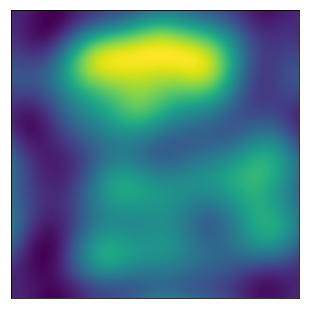

In [20]:
# Transform image to Fourier space, then multiply with uv mask and then apply the inverse FFT to reconstruct image
# Max resolution uv coverage

fft_img=np.fft.fft2(in_img)              #This is the complex visibility from a complete and ideal array from u,v =0,0 outward.
observed=fft_img*obs_uv_matrix           #Observed complex visibility. Combines ideal visibility with the observed uv points, removing those not seen by the selected array configuration.
ifft_img=np.fft.ifft2(observed)          #inverse FFTs the observed visibility
real_ifft_img=ifft_img.real              #Takes real part only for plotting

fig_obs = plt.figure(4, figsize=[4,4]) 
fig_obs.clear()
fig_obs.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax_obs=fig_obs.add_subplot(111)
ax_obs.imshow(real_ifft_img)                #Show observed version of input image.
ax_obs.get_xaxis().set_visible(False)
ax_obs.get_yaxis().set_visible(False)
fig_obs.savefig('output.png', dpi=150, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=None)

## Playing around with different kernels for convolution


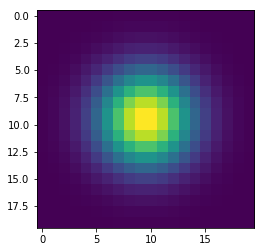

In [149]:
from scipy import fftpack
t = np.linspace(-10, 10, 20)
bump = np.exp(-0.05*t**2)
bump = bump / np.trapz(bump) # normalize the integral to 1
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
kernel_ft = fftpack.fft2(kernel, shape=(1000,1000), axes=(0, 1))
plt.imshow(kernel)

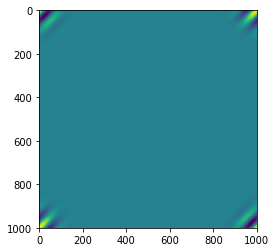

In [133]:
plt.imshow(kernel_ft.real)

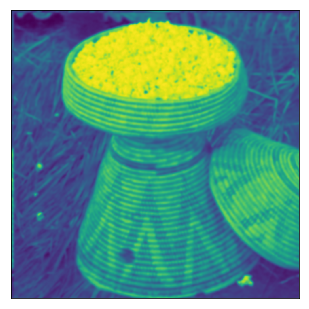

In [134]:
observed=fft_img*kernel_ft         #Observed complex visibility. Combines ideal visibility with the observed uv points, removing those not seen by the selected array configuration.
ifft_img=np.fft.ifft2(observed)          #inverse FFTs the observed visibility
real_ifft_img=ifft_img.real              #Takes real part only for plotting

fig_obs = plt.figure(4, figsize=[4,4]) #Horrific aspect ratio hack... sorry!
fig_obs.clear()
fig_obs.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax_obs=fig_obs.add_subplot(111)
ax_obs.imshow(real_ifft_img)                #Show observed version of input image.
ax_obs.get_xaxis().set_visible(False)
ax_obs.get_yaxis().set_visible(False)
fig_obs.savefig('output.png', dpi=150, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=None)

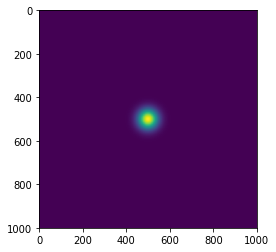

In [135]:
t = np.linspace(-500, 500, 1000)
bump = np.exp(-0.0005*t**2)
bump = bump / np.trapz(bump) # normalize the integral to 1
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
plt.imshow(np.fft.ifftshift(kernel))
plt.imshow(kernel)

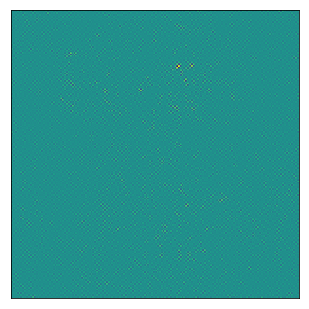

In [137]:
observed=fft_img*kernel    #Observed complex visibility. Combines ideal visibility with the observed uv points, removing those not seen by the selected array configuration.
ifft_img=np.fft.ifft2(observed)          #inverse FFTs the observed visibility
real_ifft_img=ifft_img.real              #Takes real part only for plotting

fig_obs = plt.figure(4, figsize=[4,4]) #Horrific aspect ratio hack... sorry!
fig_obs.clear()
fig_obs.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax_obs=fig_obs.add_subplot(111)
ax_obs.imshow(real_ifft_img)                #Show observed version of input image.
ax_obs.get_xaxis().set_visible(False)
ax_obs.get_yaxis().set_visible(False)
fig_obs.savefig('output.png', dpi=150, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=None)

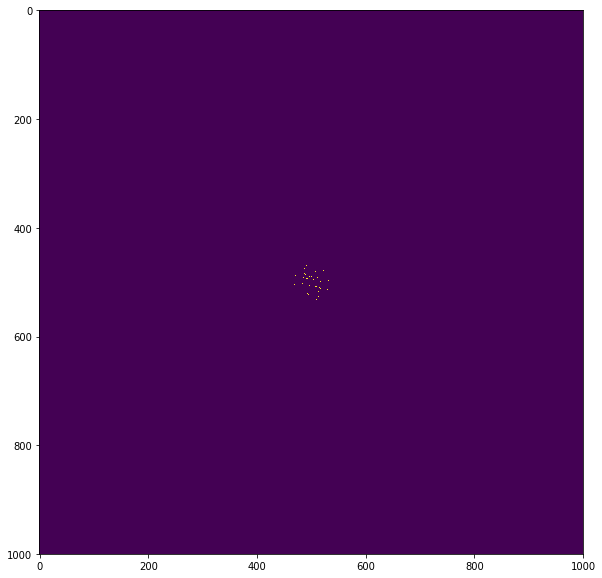

In [138]:
plt.figure(figsize=(10,10))
plt.imshow(np.fft.ifftshift(obs_uv_matrix)) # this shows what happens when we only allow high frequencies

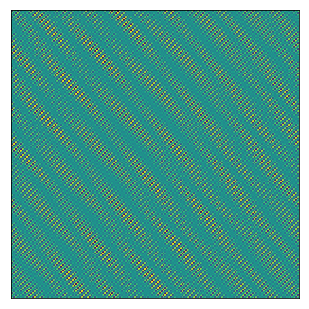

In [139]:
observed=fft_img*np.fft.ifftshift(obs_uv_matrix)*np.fft.ifftshift(kernel)        #Observed complex visibility. Combines ideal visibility with the observed uv points, removing those not seen by the selected array configuration.
ifft_img=np.fft.ifft2(observed)          #inverse FFTs the observed visibility
real_ifft_img=ifft_img.real              #Takes real part only for plotting

fig_obs = plt.figure(4, figsize=[4,4]) #Horrific aspect ratio hack... sorry!
fig_obs.clear()
fig_obs.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax_obs=fig_obs.add_subplot(111)
ax_obs.imshow(real_ifft_img)                #Show observed version of input image.
ax_obs.get_xaxis().set_visible(False)
ax_obs.get_yaxis().set_visible(False)
fig_obs.savefig('output.png', dpi=150, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=None)